In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np
# IPythonConsole.ipython_useSVG=False

In [2]:
def label(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

1
3


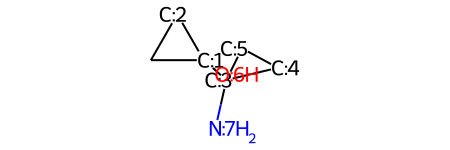

In [3]:
from rdkit.Chem.Lipinski import NumRotatableBonds, NHOHCount
test = Chem.MolFromMolFile('Resources/funky_single.mol')
print(NumRotatableBonds(test))
print(NHOHCount(test))
label(test)

6


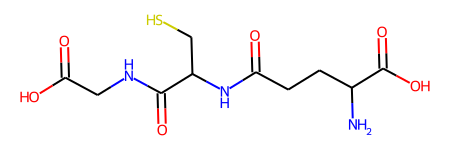

In [4]:
test2 = Chem.MolFromSmiles('C(CC(=O)NC(CS)C(=O)NCC(=O)O)C(C(=O)O)N')
print(NHOHCount(test2))
test2

In [5]:
def _diagonalize(A):
    eigenvalues_of_A, eigenvectors_of_A = np.linalg.eig(A)
    B = eigenvectors_of_A[:,abs(eigenvalues_of_A).argsort()]   
    diagonal_matrix= np.dot(np.linalg.inv(B), np.dot(A, B))
    return diagonal_matrix

In [6]:
Chem.GetDistanceMatrix(test)

array([[0., 1., 1., 2., 3., 3., 2., 3.],
       [1., 0., 1., 1., 2., 2., 1., 2.],
       [1., 1., 0., 2., 3., 3., 2., 3.],
       [2., 1., 2., 0., 1., 1., 2., 1.],
       [3., 2., 3., 1., 0., 1., 3., 2.],
       [3., 2., 3., 1., 1., 0., 3., 2.],
       [2., 1., 2., 2., 3., 3., 0., 3.],
       [3., 2., 3., 1., 2., 2., 3., 0.]])

In [7]:
def _alignment_indexes(mol, reactive_atoms, debug=True):
    '''
    Return the indexes to align the molecule to, given a list of
    atoms that should be reacting. List is composed by reactive atoms
    plus adjacent atoms.
    :param mol: rdkit Mol class molecule object
    :param reactive atoms: int or list of ints

    '''
    matrix = Chem.GetAdjacencyMatrix(mol)
    graph = nx.from_numpy_matrix(matrix)

    if type(reactive_atoms) is int:
        indexes = list([(a, b) for a, b in graph.adjacency()][reactive_atoms][1].keys())
        indexes.append(reactive_atoms)
        if debug: print('DEBUG--> Alignment indexes are', indexes)
        return indexes

    elif len(reactive_atoms) > 1:
        indexes = set()
        for atom in reactive_atoms:
            indexes |= set(list([(a, b) for a, b in graph.adjacency()][atom][1].keys()))
            indexes.add(atom)
        if debug: print('DEBUG--> Alignment indexes are', list(indexes))
        return list(indexes)


In [8]:
import networkx as nx
mol = Chem.MolFromMolFile('Resources/funky_single.mol')
reactive_atoms = [6, 7]
# mol = Chem.MolFromMolFile('Resources/CFClBrI.mol')
# reactive_atoms = 1
Chem.AddHs(mol)
# for atom in mol.GetAtoms():
#     print(atom.GetIdx(), atom.GetSymbol())

matrix = Chem.GetAdjacencyMatrix(mol)
graph = nx.from_numpy_matrix(matrix)
# graph.nodes()
# nx.draw(graph, with_labels=True)

In [9]:
_alignment_indexes(mol, 1)

DEBUG--> Alignment indexes are [0, 2, 3, 6, 1]


[0, 2, 3, 6, 1]

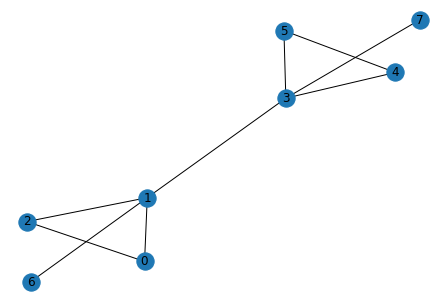

In [10]:
nx.draw(graph, with_labels=True)

In [13]:

from periodictable import core, covalent_radius, elements
from pprint import pprint
covalent_radius.init(elements)
# pt[6].covalent_radius
pprint({el:el.covalent_radius for el in elements if el.covalent_radius != None and el.covalent_radius > 2*0.76})

{Sm: 1.98,
 Pr: 2.03,
 Na: 1.66,
 K: 2.03,
 Pm: 1.99,
 Nd: 2.01,
 Hf: 1.75,
 Yb: 1.87,
 Lu: 1.87,
 Ho: 1.92,
 Ra: 2.21,
 Fr: 2.6,
 Eu: 1.98,
 W: 1.62,
 Ta: 1.7,
 Tm: 1.9,
 Er: 1.89,
 Dy: 1.92,
 Tb: 1.94,
 Gd: 1.96,
 Mo: 1.54,
 Nb: 1.64,
 Zr: 1.75,
 Ce: 2.04,
 La: 2.07,
 Ba: 2.15,
 Cs: 2.44,
 Y: 1.9,
 Sr: 1.95,
 Rb: 2.2,
 V: 1.53,
 Ti: 1.6,
 Sc: 1.7,
 Ca: 1.76,
 Cm: 1.69,
 Ac: 2.15,
 Pu: 1.87,
 Am: 1.8,
 Pa: 2.0,
 Th: 2.06,
 Np: 1.9,
 U: 1.96}


In [14]:
pt = core.PeriodicTable(table="H=1")
pt[4]

Be